# Problem Set 9 - Interpretability

## Problem 0
**(-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)**

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.5

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Description

In this problem set you will use the kaggle house price dataset to work through a couple of different feature importance metrics. We provide you with code that trains an XGBoost regression model. You should not need to edit any of the below code, but look through it to make sure you understand what's going on. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(f'feature matrix size: {X.shape}')
# the feature names
ftrs = df.columns

feature matrix size: (1460, 79)


In [3]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

train size: (876, 79)
validation size: (292, 79)
test size: (292, 79)


In [4]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [5]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (876, 220)
preprocessed validation size: (292, 220)
preprocessed test size: (292, 220)


In [7]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23150.929568295433
the test RMSE: 33542.77824967617
the test R2: 0.8370775532958903


## Problem 1 (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

In [18]:
# your code here
from sklearn.inspection import permutation_importance
import matplotlib.pylab as plt

result = permutation_importance(XGB, df_test.to_numpy(), y_test.to_numpy(), n_repeats=10, random_state=0, scoring='neg_root_mean_squared_error')
importances_values = result.importances
print("The perturbation feature importance values are:")
print(str(importances_values))

The perturbation feature importance values are:
[[-1.08345554e+02  5.24747116e+01  1.07537191e+02 ... -3.06500810e+01
  -5.64808480e+01  1.92883316e+02]
 [-3.81205551e+02 -2.51887378e+03 -1.85208228e+03 ... -2.43346848e+03
  -6.33243892e+02 -1.89977346e+03]
 [ 1.78074516e+03  1.26513113e+03  1.44674135e+03 ...  5.79414713e+02
   1.98127721e+03  1.66804635e+03]
 ...
 [ 8.39012124e+00 -5.79938181e+00 -1.37036194e+00 ... -2.05972800e+01
  -1.20798216e+01 -1.02283980e+01]
 [ 1.20031588e+00  1.43771864e+00  1.43771864e+00 ...  1.43771864e+00
   1.43771864e+00  1.43771864e+00]
 [-6.53245598e+00  3.23475236e+01  3.08840961e+01 ... -1.30786008e+01
   4.03788850e+01 -2.90573560e+01]]


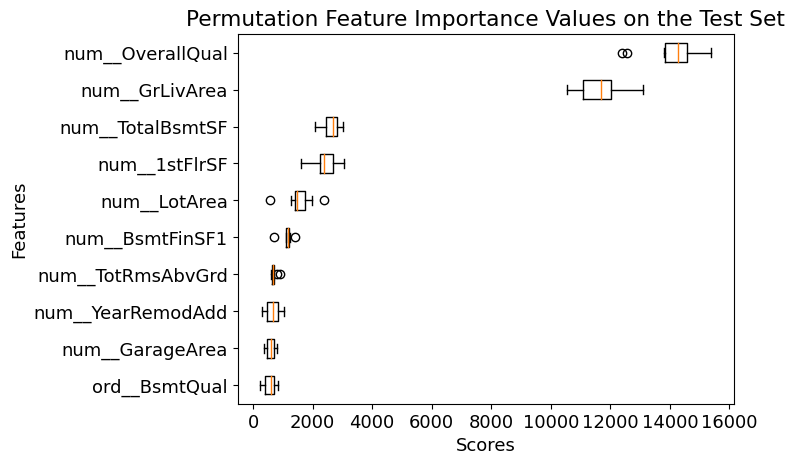

In [27]:
ftr_names = df_test.columns
test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
sorted_indices = np.argsort(np.mean(importances_values, axis=1))
plt.boxplot(importances_values[sorted_indices[-10:]].T, labels=ftr_names[sorted_indices[-10:]], vert=False)
plt.title("Permutation Feature Importance Values on the Test Set")
plt.xlabel("Scores")
plt.ylabel("Features")
plt.show()

## Problem 2 (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

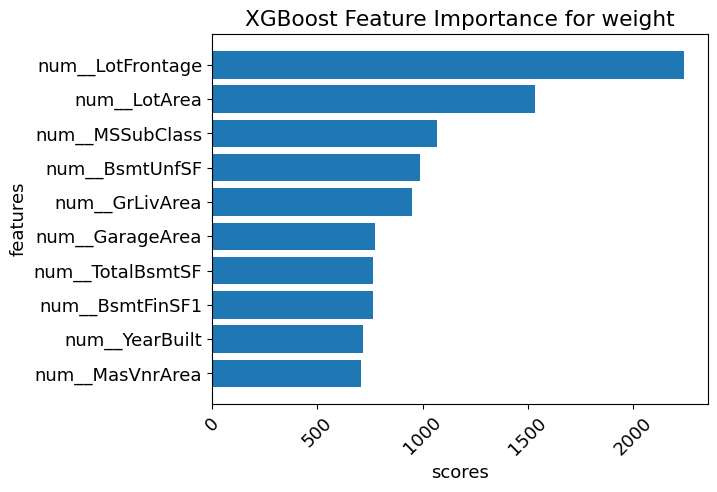

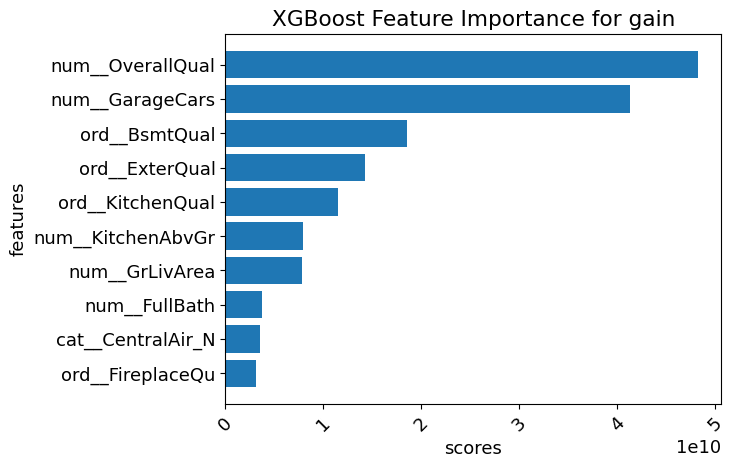

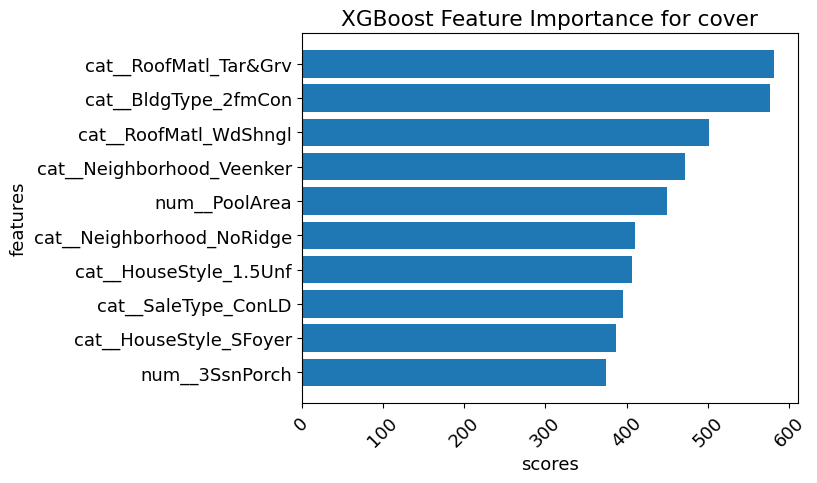

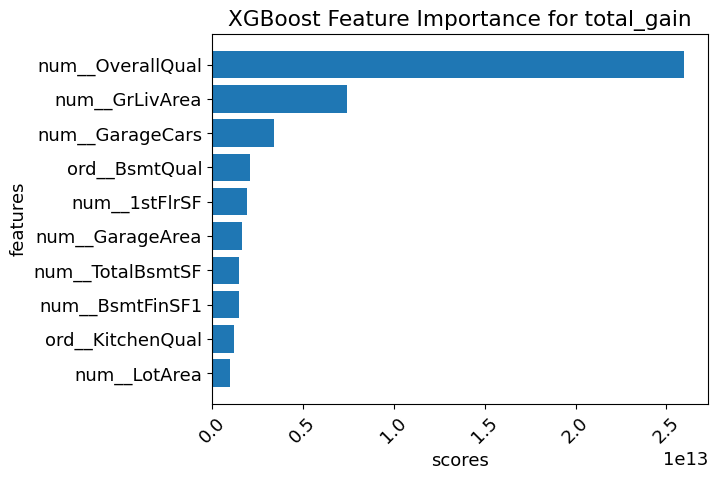

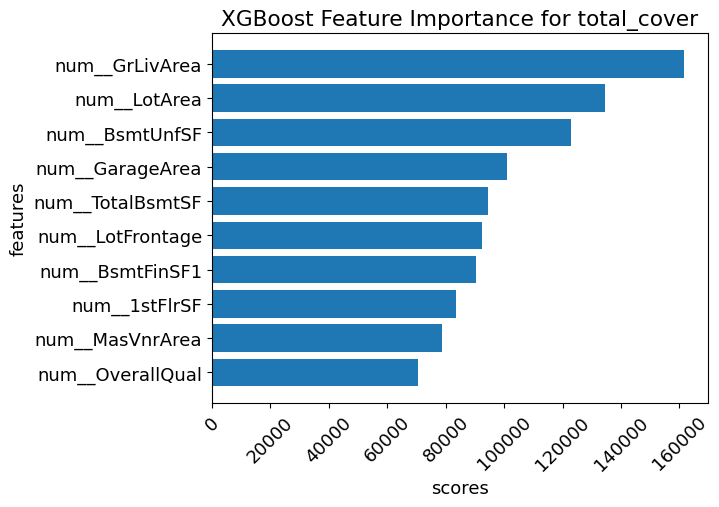

In [33]:
# your code here
metrics = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for metric in metrics:
    scores = XGB.get_booster().get_score(importance_type = metric)
    scores = dict(sorted(scores.items(), key=lambda item: item[1]))
    ftr_names_tmp = list(scores.keys())[-10:]
    summary = list(scores.values())[-10:]
    plt.barh(ftr_names_tmp, summary)
    plt.xlabel('scores')
    plt.ylabel('features')
    plt.title('XGBoost Feature Importance for ' + metric)
    plt.xticks(rotation = 45)
    plt.show()

## Problem 3a (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

(292, 220)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


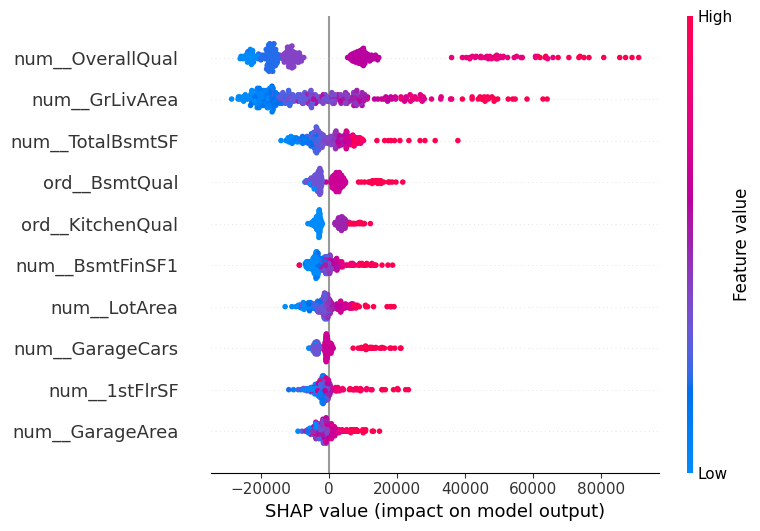

In [37]:
# your code here
import shap

shap.initjs()
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(df_test)
print(shap_values.shape)
shap.summary_plot(shap_values, df_test, feature_names = feature_names, max_display=10)

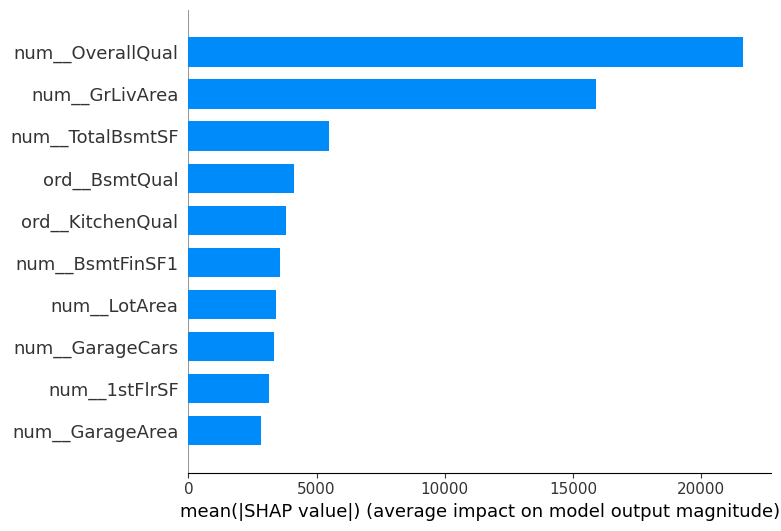

In [38]:
shap.summary_plot(shap_values, df_test, feature_names=feature_names, max_display=10, plot_type='bar')

## Problem 3b (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

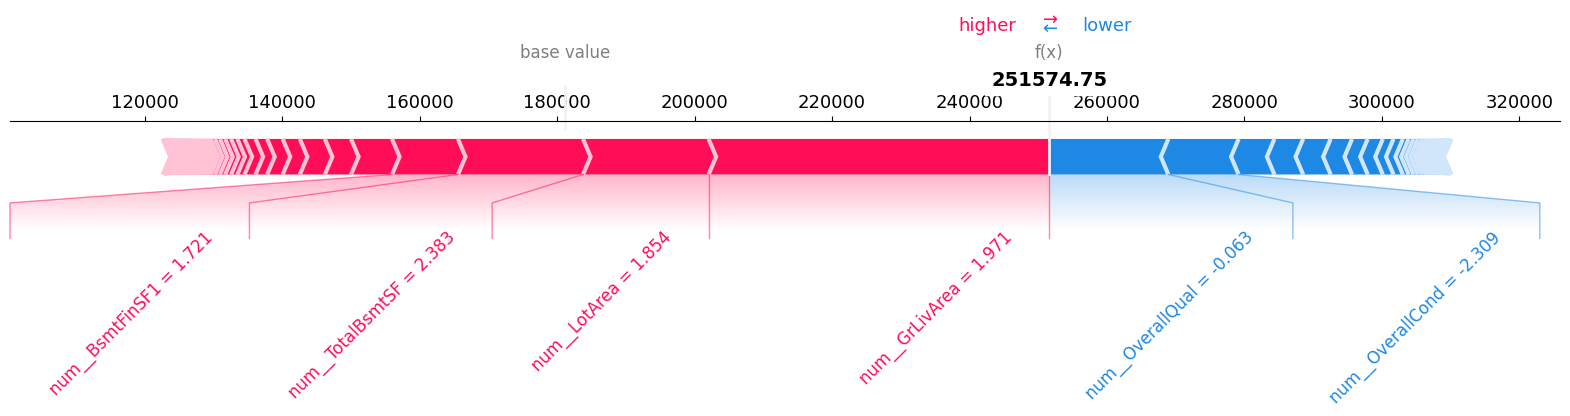

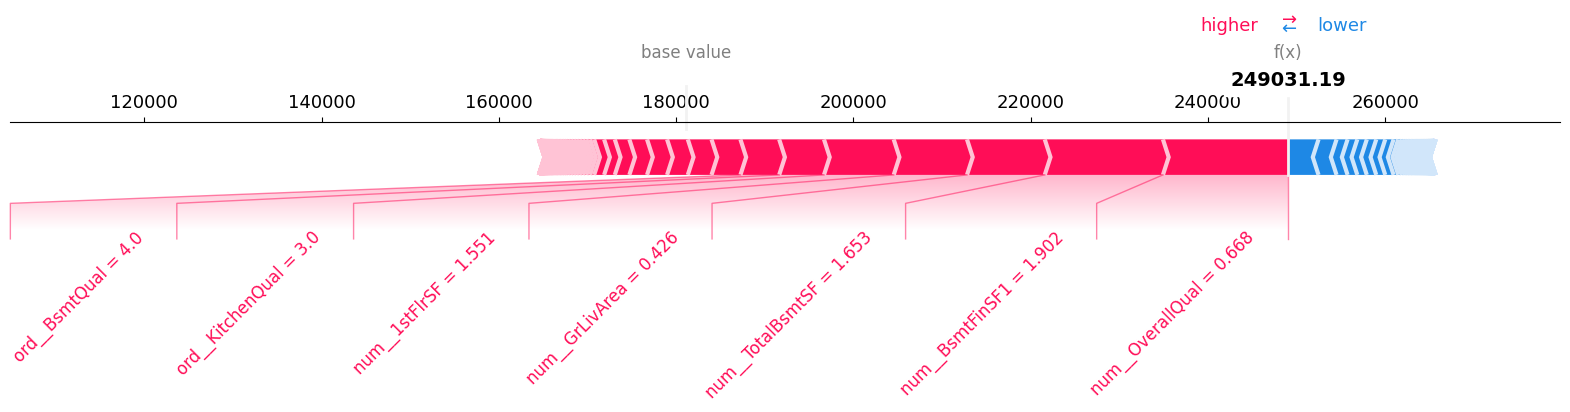

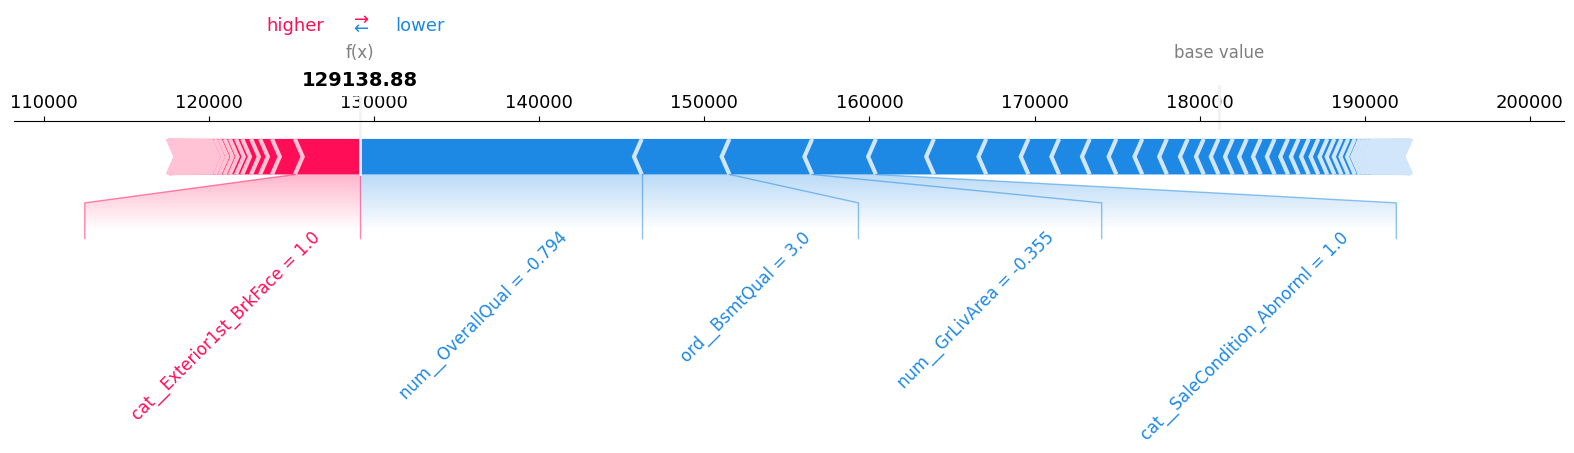

In [44]:
# your code here
from xgboost import XGBRegressor

indices = [0, 100, 200]

for index in indices:
    shap.force_plot(explainer.expected_value, np.round(shap_values[index, :], 3), features=np.round(df_test.iloc[index,:], 3),
                    feature_names = feature_names, matplotlib = True, text_rotation = 45)


**your explanation here**

For data point index 0, features that contribute positively are num_BsmtFinSF1, num_TotalBsmtSF, num_LotArea, and num_GrLivArea. Features that contribute negatively are num_OverallQual and num_OverallCond. 

For data point index 100, features that contribute positively are ord_BsmtQual, ord_KitchenQual, num_1stFlrSF, num_GrLivArea, num_TotalBsmtSF, num_BsmtFinSF1, and num_OverallQual. There isn't feature that contribute negatively to the prediction. 

For data point index 200, feature that contribute positively is cat_Exterior1st_BrkFace. Features that contribute negatively are num_OverallQual, ord_BsmtQual, num_GrLivArea, and cat_SaleCondition_Abnormal. 

## Problem 4 (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranking of features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

**Perturbation Method**:

Principle: It measures the impact on model performance when a feature's values are randomly shuffled, disrupting the relationship between the feature and the target.

Pros: Directly measures the impact on performance, intuitive.

Cons: Computationally intensive, may not capture interactions between features.

**XGBoost Metrics:**

Weight (Frequency): Counts the number of times a feature is used in the trees.

                    Pros: Easy to calculate and understand.

                    Cons: May favor features with more categories, doesn't account for the actual impact on model performance.


Gain (Average Gain of Splits): Average gain of the feature when used in splits.

                    Pros: Considers the quality of the splits, more informative than weight.

                    Cons: Can be biased towards features with more categories.


Cover (Average Coverage of Splits): Measures the number of instances affected by the feature.

                    Pros: Reflects the influence of a feature over the data.

                    Cons: Might not fully capture the feature's predictive power.


Total Gain and Total Cover: Aggregate versions of gain and cover over all splits.

                    Pros: Capture overall impact better than average measures.

                    Cons: Similar biases as their average counterparts.

**Global SHAP (SHapley Additive exPlanations):**

Principle: Based on game theory, SHAP values represent the average impact of a feature value on the prediction in comparison to the average prediction.

Pros: Considers feature interactions, provides a more holistic view, rooted in solid theoretical foundation.

Cons: Computationally expensive, interpretation can be complex.

**Comparative Analysis:**

Ranking Consistency: It's common to see some features consistently ranked high by different methods. These are likely to be genuinely influential features in the model. If certain features consistently appear in the top 3-5 across different methods, it indicates robustness in their predictive power.

Differences in Rankings: Different methods emphasize different aspects of feature importance. For instance, while SHAP values account for interactions and marginal contributions, XGBoost's gain focuses more on how much a feature improves the splits. Perturbation assesses the impact on model performance directly, which might not always align with how often or how significantly a feature is used in the model.

**Pros and Cons Analysis:**

Accuracy vs. Interpretability: Methods like SHAP are theoretically sound and provide detailed insights but are complex and computationally heavy. In contrast, simpler metrics like weight from XGBoost are easy to interpret but might not capture the true impact of a feature.

Bias Toward Feature Characteristics: Some methods might inherently favor features with more categories or higher variability, leading to potentially misleading importance rankings.

In summary, when interpreting feature importance rankings from multiple metrics, it's crucial to understand the underlying principles of each method. Features consistently ranked high are likely key drivers in the model. However, the variability in rankings across methods highlights the multifaceted nature of feature importance and the need to consider multiple perspectives when evaluating features in a predictive model.